In [0]:

import torch
from torch import nn
from torchvision import transforms
from torch.autograd import Variable
from sklearn.manifold import Isomap

import torch.distributions as torch_dist
import numpy as np
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt


In [0]:
# These two lists are used to plot the loss of the VAE
loss_graph1_x = []
loss_graph1_y = []


iterations = 0
batch_size = 32
input_dim = 784
h1_dim = 600
h2_dim = 400
h3_dim = 300
h4_dim = 250
h5_dim = 200               # bottleneck / latent representation
h6_dim = 250
h7_dim = 300
h8_dim = 400
h9_dim = 600
output_dim = 784

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('place your own file path here:',
                                   download = True, transform = transform)
dataloader = torch.utils.data.DataLoader(mnist, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [0]:

class VAE(torch.nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        """
        The encoder and decoder each have 4 hidden layers:
        
        
        Layer Dimensions:
        
        Encoding layer 1 -> 784 input pixels - 500 output pixels        Input
        Encoding layer 2 -> 500 input pixels - 300 output pixels        Hidden 1
        Encoding layer 3 -> 300 input pixels - 200 output pixels        Hidden 2
        Encoding layer 4 -> 200 input pixels - 100 output pixels        Hidden 3
        Encoding layer 5 -> 100 input pixels - 100 output pixels        Hidden 4
        
        100 - 20 Encoding mean                                        Bottleneck
        100 - 20 Encoding stddev                                      Bottleneck
        
        Decoder layer 1 -> 20 input pixels,  100 output pixels          Hidden 1
        Decoder layer 2 -> 100 input pixels, 200 output pixels          Hidden 2
        Decoder layer 3 -> 200 input pixels, 300 output pixels          Hidden 3
        Decoder layer 4 -> 300 input pixels, 500 output pixels          Hidden 4
        Decoder layer 5 -> 500 input pixels, 784 output pixels          Output
        """
        
        self.enc_layer1 = torch.nn.Linear(input_dim, h1_dim)
        self.enc_layer2 = torch.nn.Linear(h1_dim, h2_dim)
        self.enc_layer3 = torch.nn.Linear(h2_dim, h3_dim)
        self.enc_layer4 = torch.nn.Linear(h3_dim, h4_dim)
        self.enc_layer5 = torch.nn.Linear(h4_dim, h4_dim)
        
        self.enc_mean =   torch.nn.Linear(h4_dim, h5_dim) # mean
        self.enc_stddev = torch.nn.Linear(h4_dim, h5_dim) # standard deviation
        
        self.dec_layer1 = torch.nn.Linear(h5_dim, h6_dim)
        self.dec_layer2 = torch.nn.Linear(h6_dim, h7_dim)
        self.dec_layer3 = torch.nn.Linear(h7_dim, h8_dim)
        self.dec_layer4 = torch.nn.Linear(h8_dim, h9_dim)
        self.dec_layer5 = torch.nn.Linear(h9_dim, output_dim)
    
    
    # This is the encoder. I am passing the input through linear layers
    def encode(self, x):
        h1 = F.relu(self.enc_layer1(x))
        h2 = F.relu(self.enc_layer2(h1))
        h3 = F.relu(self.enc_layer3(h2))
        h4 = F.relu(self.enc_layer4(h3))
        return self.enc_layer5(h4)
    
    
    
    
    # In this function, the mean and standard deviations are being randomly
    # sampled.
    def get_latent_variables(self, x):
        
        mu = self.enc_mean(x)
        sigma = self.enc_stddev(x)
        
        # Below is the reparametrization trick. The shape of the samples 
        # matches the shape of the standard deviation layer from the encoder
        random_samples = sigma.data.new(sigma.size()).normal_(mean = 0, std = 1)
        
        self.z_mean = mu
        self.z_stddev = torch.exp(sigma)
        
        # It is very important to use the reparametrization trick because
        # it can rewrite an expectation to make it differentiable. You want it
        # to be differentiable.
        return mu + (sigma * random_samples)
    
    
    # This is the decoder. Just like the encoder, the latent representation
    # of the data is being passed through linear layers.
    def decode(self, z):
        d_layer1 = F.relu(self.dec_layer1(z))
        d_layer2 = F.relu(self.dec_layer2(d_layer1))
        d_layer3 = F.relu(self.dec_layer3(d_layer2))
        d_layer4 = F.relu(self.dec_layer4(d_layer3))
        return torch.sigmoid(self.dec_layer5(d_layer4))

    # This forward function pieces together the VAE. It takes in the input,
    # passes it to the encoder, calculates the latent variables, and decodes 
    # them.
    def forward(self, x):
        x = self.encode(x)
        x = self.get_latent_variables(x)
        return self.decode(x)


# This function calculates the Kullback-Leibler divergence.
# The purpose of using the KL divergence is to keep the VAE from 
# overfitting (memorizing) the data.
def latent_loss(mean, stddev):
    mean_sq = mean * mean
    variance = stddev * stddev
    
    return torch.mean(0.5 * (variance + mean_sq) - 0.5 - torch.log(stddev))




Epoch 9 : Combined Loss 0.02218455635011196


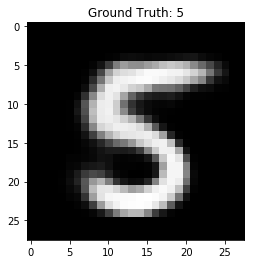

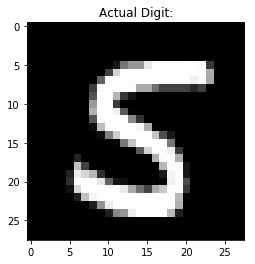

In [5]:
if __name__ == '__main__':
    
    # Setting up the variables
    vae = VAE()
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
    l = None
    mse_loss = torch.nn.MSELoss()
    
    
    # This is the VAE training loop
    for epoch in range(10):
        vae.train()
        
        
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = inputs.to(device), classes.to(device)
            
            
            # In this spot, I am reshaping the input images in order to pass
            # them through the VAE. If I didn't reshape the input, it would be:
            #
            # size: ([32, 1, 28, 28])
            # format: ([batch_size, channels, image_dimension, image_dimension])
            #
            # In this case, I am resizing the inputs to size: ([32, 784]).
            inputs, classes = inputs.resize_(batch_size, input_dim), classes
            
            optimizer.zero_grad()
            
            
            
            # Forward propagation:
            network_output = vae(inputs)
            
            
            
            # Backpropagation
            ll = latent_loss(vae.z_mean, vae.z_stddev)
            # I am using the mean squared error loss
            decoder_loss = mse_loss(inputs, network_output)
            # It is important to use the latent loss (ll) to penalize the
            # decoder loss in order to prevent overfitting.
            combined_loss = decoder_loss + ll
            combined_loss.backward()
            optimizer.step()
            
            
            
            # These lines are being used to create a graph of the loss
            # during training.
            iterations += 1
            loss_graph1_x.append(iterations)
            loss_graph1_y.append(combined_loss)
            
# These lines print off the last training digit in the last epoch of training.
print('Epoch {} : Combined Loss {}'.format(epoch, combined_loss))
plt.title("Ground Truth: {}".format(classes[0]))
plt.imshow(vae(inputs).cpu().data[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show(block = True)
plt.title("Actual Digit:")
plt.imshow(inputs.cpu().data[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show(block = True)

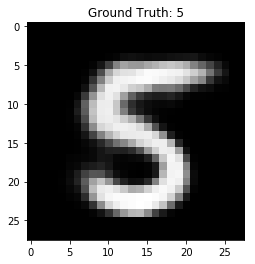

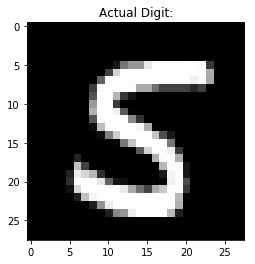

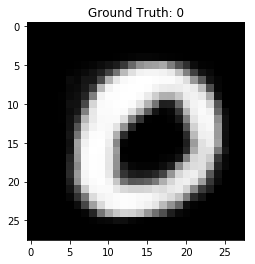

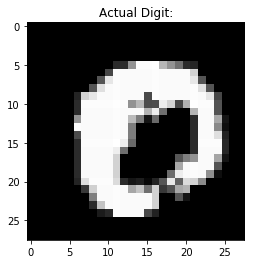

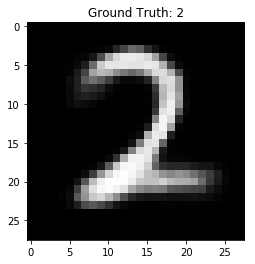

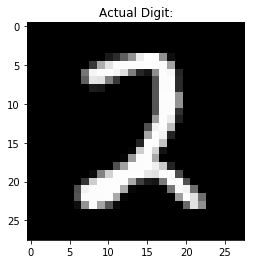

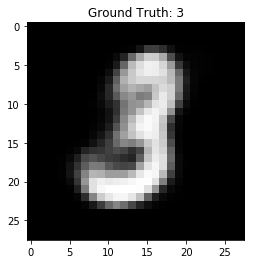

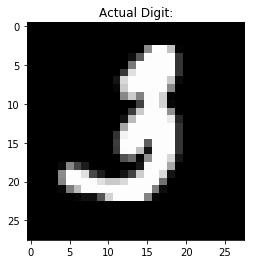

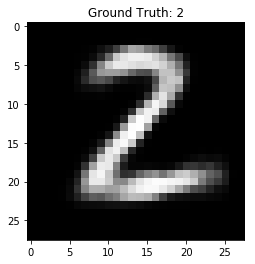

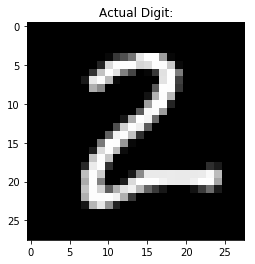

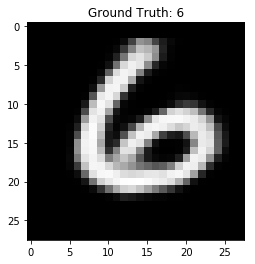

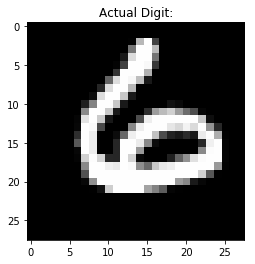

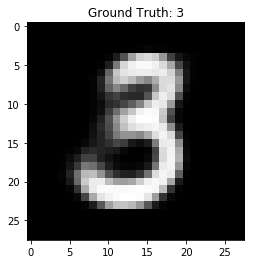

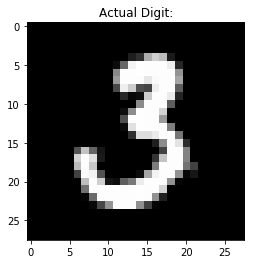

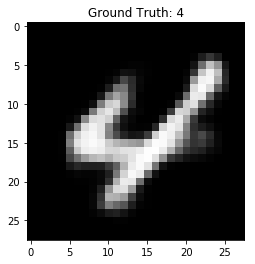

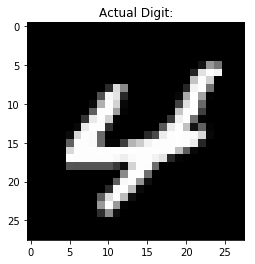

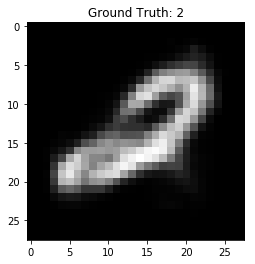

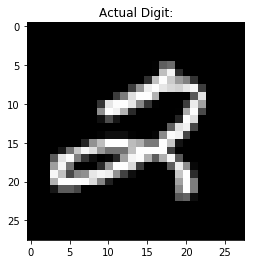

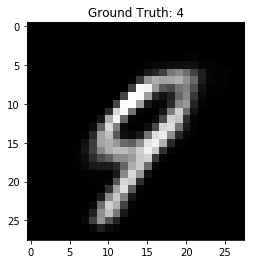

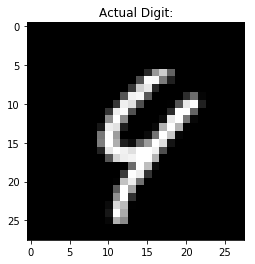

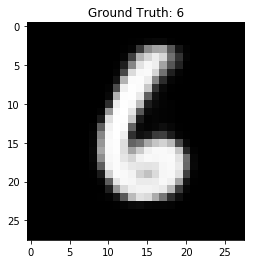

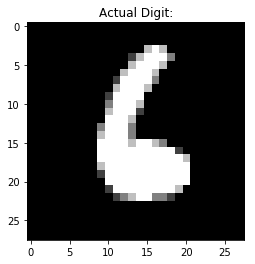

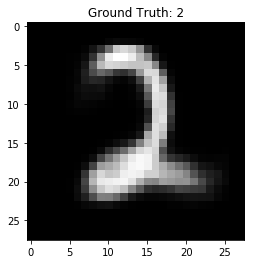

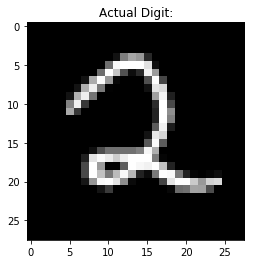

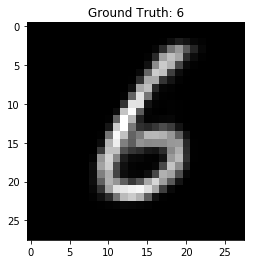

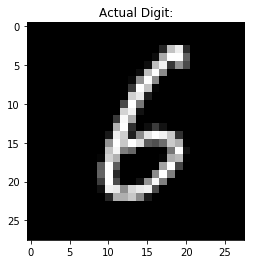

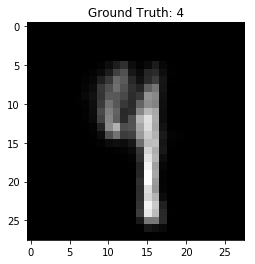

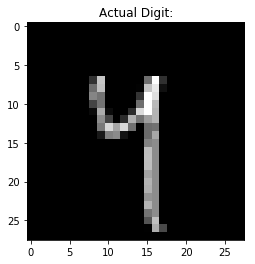

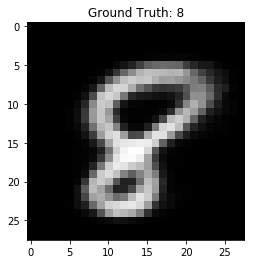

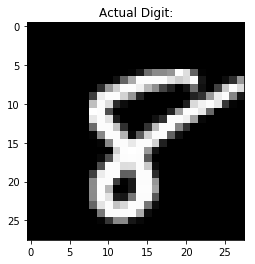

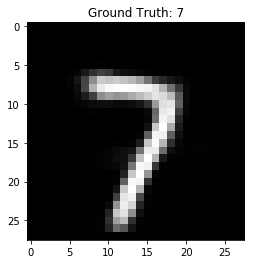

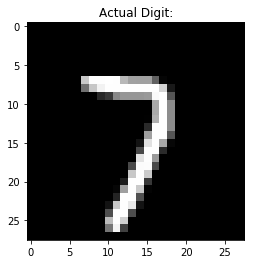

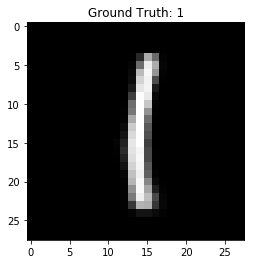

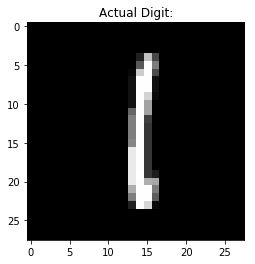

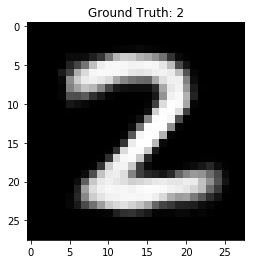

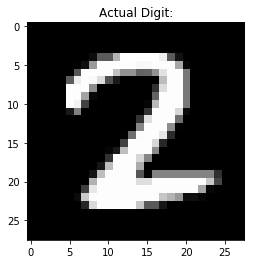

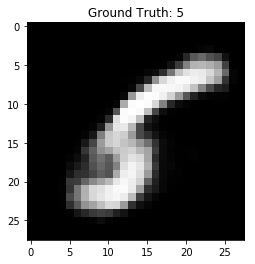

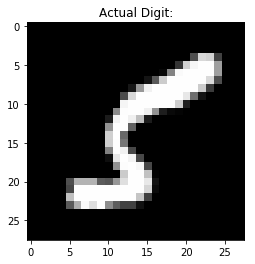

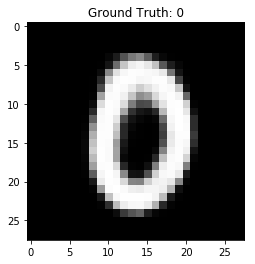

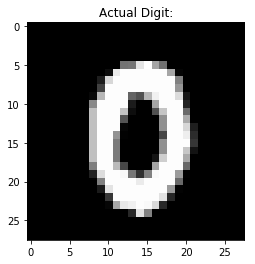

In [6]:
# This loop prints off multiple digits from the last epoch of training.

for i in range(20):
    plt.title("Ground Truth: {}".format(classes[i]))
    plt.imshow(vae(inputs).cpu().data[i].numpy().reshape(28, 28), cmap = 'gray')
    plt.show(block = True)
                
    plt.title("Actual Digit:")
    plt.imshow(inputs.cpu().data[i].numpy().reshape(28, 28), cmap = 'gray')
    plt.show(block = True)

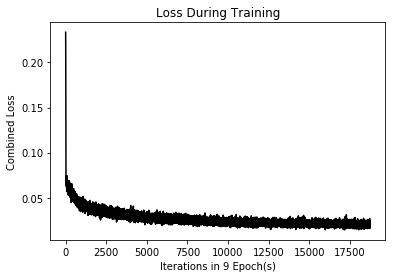

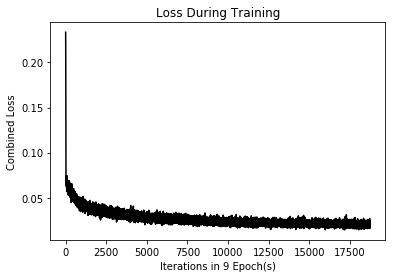

In [9]:

# This is for the graph of the loss
fig = plt.figure()
plt.plot(loss_graph1_x, loss_graph1_y, color = 'black')
plt.title("Loss During Training")
plt.xlabel("Iterations in {} Epoch(s)".format(epoch))
plt.ylabel("Combined Loss")
fig

(100, 28, 28)


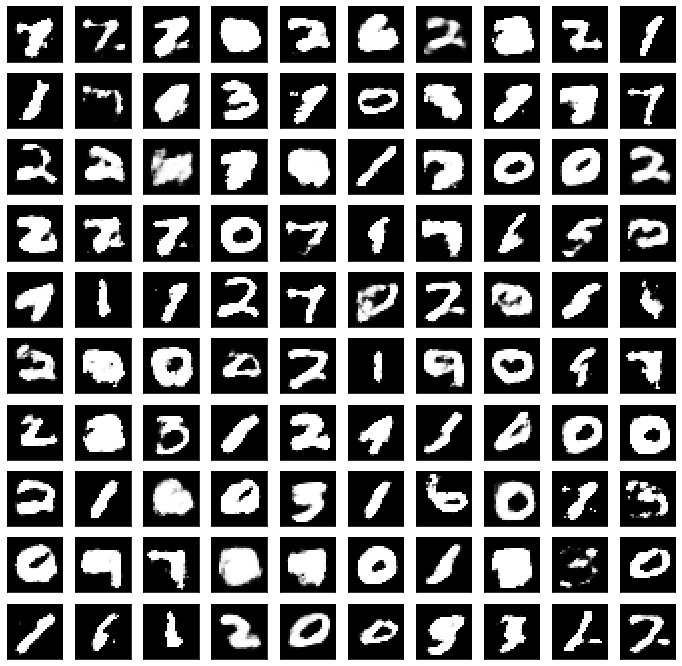

In [8]:
# This code on this block was taken from:
# https://github.com/Gaurav927/Variational_Auto_Encoder/blob/master/Variational_AE.ipynb


# This block generates random numbers for the VAE to draw.
def generate_digits(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean = np.zeros(h5_dim), cov = np.eye(h5_dim), size = batch_size)).type(torch.float) # 50 is the latent space dimension / bottleneck


z = generate_digits(100).to(device)
generated_images = Variable( vae.decode(z), requires_grad = False )
z = generated_images.reshape((100, 28, 28))
z = z.cpu().detach().numpy()
fig = plt.figure(figsize = (12, 12))

print(z.shape)

columns = 10
rows = 10
for i in range(1, columns*rows + 1):
    img = z[i-1]
    fig.add_subplot(rows, columns, i)
    
    show = plt.imshow(img, cmap = 'gray')
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.savefig('result.jpg')
plt.show()